In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import sys
import sqlite3
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration

In [3]:
stack = 'MD594'
db_dir = os.environ['ROOT_DIR'] + 'CSHL_databases/'
if not os.path.exists(db_dir):
    os.mkdir(db_dir)
db_dir += stack + '/'
if not os.path.exists(db_dir):
    os.mkdir(db_dir)
img_dir = os.environ['ROOT_DIR'] + 'CSHL_cells_images/'
if not os.path.exists(img_dir):
    os.mkdir(img_dir)
img_dir += stack + '/'
if not os.path.exists(img_dir):
    os.mkdir(img_dir)

In [2]:
def setup_download_from_s3( rel_fp, recursive=True ):
    s3_fp = 's3://mousebrainatlas-data/'+rel_fp
    local_fp = os.environ['ROOT_DIR']+rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return 
    
    if recursive:
        ! aws s3 cp --recursive $s3_fp $local_fp
    else:
        ! aws s3 cp $s3_fp $local_fp

In [3]:
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}

NameError: name 'stack' is not defined

In [129]:
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
section = 99
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)

ALREADY DOWNLOADED FILE


In [184]:
conn = sqlite3.connect(db_dir+str(section)+'.db')
cur = conn.cursor()

In [131]:
cur.execute('''CREATE TABLE Features 
               (section int, x int, y int,
                DMVec1 real, DMVec2 real, DMVec3 real, DMVec4 real, DMVec5 real,
                DMVec6 real, DMVec7 real, DMVec8 real, DMVec9 real, DMVec10 real,
                area int, height int, horiz_std real, mean real, padded_size int,
                rotation real, rotation_confidence real, std real, vert_std real, width int)''')

In [168]:
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape

In [133]:
m, n

(11104, 17216)

In [134]:
xs, ys = np.meshgrid(np.arange(0, n, 1000), np.arange(0, m, 1000), indexing='xy')
locations = np.c_[xs.flat, ys.flat]

In [135]:
yamlfile=os.environ['REPO_DIR']+'shape_params.yaml'
params=configuration(yamlfile).getParams()
extractor = patch_extractor(params)
images_all = pd.DataFrame()

/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))


In [136]:
left = locations[87][0]
right = int(min(left+1000, n))
up = locations[87][1]
down = int(min(up+1000,m))

In [145]:
%%time
tile = img[up:down, left:right]
if params['preprocessing']['polarity']==-1:
    tile = 255-tile
Stats = extractor.segment_cells(tile)
cells = extractor.extract_blobs(Stats,tile)
cells = pd.DataFrame(cells)
#cells = cells[cells['padded_patch'].notnull()]

CPU times: user 36.8 ms, sys: 2.74 ms, total: 39.5 ms
Wall time: 36.9 ms


In [180]:
tile = img[up:down, left:right]
type(tile)
tile.max()

255

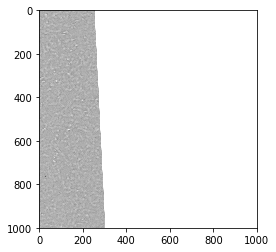

In [181]:
tile=tile/tile.max()*255
tile=tile.astype(np.uint8)
imshow(tile,cmap='gray')

In [182]:
cells

Empty DataFrame
Columns: []
Index: []

In [116]:
cells['section'] = section
cells['x'] = cells['left'] + left + cells['width']/2
cells['y'] = cells['top'] + up +cells['height']/2
cells = cells.astype({'x': int, 'y': int})

In [108]:
images = cells[['section', 'x', 'y', 'padded_patch']]
images_all =pd.concat([images_all, images], ignore_index=True)
# img_out_file = img_dir + str(section)
# images.to_pickle(img_out_file)

In [117]:
cells = cells.drop(['padded_patch','left','top'],1)
cells = np.asarray(cells)
for k in range(len(cells)):
    cells[k][0] = cells[k][0][:10]
features = np.concatenate((cells[:,-3:], np.array(list(cells[:,0])),cells[:,1:-3]),axis=1)

In [121]:
features[0:2]

array([[168, 1593, 6, 4.109909885617509, -1.2870128070762894,
        -1.2004753207204446, -0.049244788371834665, -1.0571741505949546,
        1.2042090636916432, -0.36240426772481044, 0.10882032869778066,
        0.8005821558939126, -0.2696772283188138, 110, 10,
        2.136481069191512, 5.9640831758034025, 51, -83.3477111226304,
        1364.9723659289205, 13.132616978207176, 3.6762074158920113, 16],
       [168, 1020, 15, -1.583713977883637, 1.4405948019673338,
        -1.3954528174412069, -0.32175728155479827, 1.030303528007469,
        0.7542561751778836, -0.18481647782551552, 0.7866518465343114,
        -0.7555683035607482, 0.22366372819162036, 320, 24,
        4.688070508986538, 9.798269334775554, 51, 83.93008264822427,
        1287.652059588039, 23.149778665851613, 5.487856302159731, 25]],
      dtype=object)

In [118]:
cur.executemany('INSERT INTO Features VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)', features)

In [185]:
cur.execute('SELECT * FROM features')
cur.fetchone()

(99,
 582,
 28,
 2.1569347383013837,
 -0.01914680328072571,
 -1.6122909279649926,
 -0.23599463104881072,
 -0.21962428264338862,
 0.5443551698033889,
 0.5093988511999487,
 -0.6378635931132551,
 -0.06127104029023334,
 -0.31247472113482994,
 16,
 6,
 0.7490711464169707,
 1.4938271604938271,
 15,
 -9.379061332401117,
 105.69843182163682,
 3.8622051424955535,
 1.1953065917778858,
 4)

In [120]:
cur.fetchone()

(168,
 1020,
 15,
 -1.583713977883637,
 1.4405948019673338,
 -1.3954528174412069,
 -0.32175728155479827,
 1.030303528007469,
 0.7542561751778836,
 -0.18481647782551552,
 0.7866518465343114,
 -0.7555683035607482,
 0.22366372819162036,
 320,
 24,
 4.688070508986538,
 9.798269334775554,
 51,
 83.93008264822427,
 1287.652059588039,
 23.149778665851613,
 5.487856302159731,
 25)

In [183]:
script = os.environ['REPO_DIR']
! python $script/Sqlite.py 'MD594' 99 'shape_params.yaml'

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
0 216
1 216
2 216
3 216
4 216
5 216
6 216
7 216
8 216
9 216
10 216
11 216
12 216
13 216
14 216
15 216
16 216
17 216
18 216
19 216
20 216
21 216
22 216
23 216
24 216
25 216
26 216
27 216
28 216
29 216
30 216
31 216
32 216
33 216
34 216
35 216
36 216
37 216
38 216
39 216
40 216
41 216
42 216
43 216
44 216
45 216
46 216
47 216
48 216
49 216
50 216
51 216
52 216
53 216
54 216
55 216
56 216
57 216
58 216
59 216
60 

In [187]:
a = np.array([0,1,2,3,4,5,6,7,8])
a[0::2]

array([0, 2, 4, 6, 8])

In [4]:
setup_download_from_s3('CSHL_databases/MD594/')

download: s3://mousebrainatlas-data/CSHL_databases/MD594/102.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/102.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/103.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/103.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/105.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/105.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/106.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/106.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/104.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/104.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/107.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/107.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/110.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/110.db
download: s3://mousebrainatlas-data/CSHL_databas

download: s3://mousebrainatlas-data/CSHL_databases/MD594/225.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/225.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/223.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/223.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/228.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/228.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/224.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/224.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/230.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/230.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/229.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/229.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/233.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/233.db
download: s3://mousebrainatlas-data/CSHL_databas

download: s3://mousebrainatlas-data/CSHL_databases/MD594/328.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/328.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/347.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/347.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/349.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/349.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/350.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/350.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/348.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/348.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/354.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/354.db
download: s3://mousebrainatlas-data/CSHL_databases/MD594/351.db to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/351.db
download: s3://mousebrainatlas-data/CSHL_databas

In [6]:
section = 200
conn = sqlite3.connect(db_dir+str(section)+'.db')
cur = conn.cursor()

In [31]:
%%time
raws = cur.execute('SELECT * FROM features WHERE x >= 1000 AND x <= 5000 AND y >= 1000 AND y<= 5000')
print(len(list(raws)))

15025
CPU times: user 96.6 ms, sys: 14.5 ms, total: 111 ms
Wall time: 115 ms


In [30]:
133/18718

0.007105459985041137

In [24]:
len(a)

876

In [9]:
n = 0
for raw in raws:
    print(raw)

(200, 3084, 3014, 2.8063508317196137, 0.41663084002137835, -0.6087435827140384, -1.005744267317436, -0.035277336306381454, 0.38430734506368236, -0.9194480777374305, 0.1343451179478285, 0.8817521485524208, 0.44530176867276117, 11, 5, 0.7649733699239392, 0.21487603305785125, 15, 31.181339789411567, 51.68344327324016, 0.8352424458262901, 1.042365442947645, 4)
(200, 3084, 3020, 2.242259712337181, 0.24233601946283329, -1.7525435972118415, -0.30743426179201044, -0.6578714578770994, 0.7442296623715077, -0.23504383743867563, 0.3777217744777256, 1.182018537070366, -0.21215585059813824, 13, 4, 0.6021847415896182, 0.5867768595041323, 15, -89.55726869737848, 258.8235294115173, 2.126843085935535, 1.1115166003914925, 6)
(200, 3057, 3038, 1.6757686229341842, 0.4679210433155536, -2.2619015264772737, 1.0768099877578414, 0.3709032258652196, 0.5657124818271475, -0.2788961368576143, 0.26751960463925567, -0.993407575341686, -0.8217357053167456, 15, 5, 0.7925142029197664, 0.9504132231404959, 15, -49.0528789

In [4]:
import bloscpack

In [5]:
stack = 'MD594'
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}
    filename_to_section = {fn: int(idx) for fn, idx in fn_idx_tuples}

ALREADY DOWNLOADED FILE


In [28]:
section = 159
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)

download: s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_lossless_gray.tif to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_lossless_gray.tif


In [6]:
fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')

ALREADY DOWNLOADED FILE


In [8]:
setup_download_from_s3('CSHL_scoremaps/down32/' + stack +'/'+ stack+ '_prep2_down32_detector1/' )

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1_5N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_down32_detector1_SNR_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_prep2_down32_detector1_Amb_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1_7n_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_prep2_down32_detector1_SNC_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_prep2_down32_detector1_Amb_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1_10N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_prep2_down32_detector1_Sp5C_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1_7n_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_prep2_down32_detector1_Tz_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_prep2_down32_detector1_LC_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1_4N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_prep2_down32_detector1_SC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_prep2_down32_detector1_LRt_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_prep2_down32_detector1_4N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_prep2_down32_detector1/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_prep2_down32_detector1_IC_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1_Amb_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_down32_detector1_SNC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1_7N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_down32_detector1_Sp5C_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_down32_detector1_RMC_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_down32_detector1/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_down32_detector1_VCA_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_prep2_down32_detector1_AP_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1_AP_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_prep2_down32_detector1_Sp5I_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_prep2_down32_detector1_SC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1_6N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_prep2_down32_detector1_10N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_prep2_down32_detector1_PBG_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_prep2_down32_detector1_10N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_prep2_down32_detector1/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_prep2_down32_detector1_Sp5C_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_prep2_down32_detector1_LC_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_prep2_down32_detector1_IC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_prep2_down32_detector1/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_prep2_down32_detector1_SNC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1_Amb_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_prep2_down32_detector1_Tz_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_prep2_down32_detector1_PBG_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_prep2_down32_detector1/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_prep2_down32_detector1_RMC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1_LRt_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_prep2_down32_detector1_IC_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_prep2_down32_detector1/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_prep2_down32_detector1_VCP_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_prep2_down32_detector1_5N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1_6N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_prep2_down32_detector1_VCA_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_prep2_down32_detector1_Amb_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_prep2_down32_detector1_4N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_prep2_down32_detector1/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_prep2_down32_detector1_SNR_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_prep2_down32_detector1_AP_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_prep2_down32_detector1_12N_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_prep2_down32_detector1/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_prep2_down32_detector1_SC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1_10N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_prep2_down32_detector1_VLL_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_prep2_down32_detector1/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_prep2_down32_detector1_Pn_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1_7N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_prep2_down32_detector1_Sp5O_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_prep2_down32_detector1/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_prep2_down32_detector1_LC_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1_4N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_prep2_down32_detector1_RtTg_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_prep2_down32_detector1_7N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_prep2_down32_detector1/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1_10N_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1_12N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_prep2_down32_detector1_7n_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_prep2_down32_detector1/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_prep2_down32_detector1_Pn_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_prep2_down32_detector1_7n_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1_12N_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_prep2_down32_detector1_RtTg_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1_6N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_prep2_down32_detector1_Tz_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_prep2_down32_detector1/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_prep2_down32_detector1_Pn_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1_3N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_prep2_down32_detector1_SNC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_prep2_down32_detector1_Amb_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_prep2_down32_detector1/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1_10N_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1_RtTg_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_prep2_down32_detector1_DC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_prep2_down32_detector1/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_prep2_down32_detector1_VCA_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_prep2_down32_detector1_7N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1_3N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_prep2_down32_detector1_SNC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1_Amb_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_prep2_down32_detector1_VCA_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_prep2_down32_detector1/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_prep2_down32_detector1_Pn_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1_6N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_prep2_down32_detector1_Sp5I_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_prep2_down32_detector1/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_prep2_down32_detector1_IC_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1_12N_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_prep2_down32_detector1_SC_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1_AP_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_prep2_down32_detector1_VCA_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_prep2_down32_detector1_Pn_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1_4N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_prep2_down32_detector1_Sp5C_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_prep2_down32_detector1_DC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_prep2_down32_detector1_10N_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_prep2_down32_detector1/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_prep2_down32_detector1_SC_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1_7n_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_prep2_down32_detector1_Sp5O_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_prep2_down32_detector1/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_prep2_down32_detector1_PBG_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1_5N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_prep2_down32_detector1_Sp5I_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_prep2_down32_detector1_AP_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_prep2_down32_detector1/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_prep2_down32_detector1_10N_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_prep2_down32_detector1_RtTg_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1_7N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_prep2_down32_detector1_Sp5O_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_prep2_down32_detector1_LC_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1_3N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_prep2_down32_detector1_SNR_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1_DC_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_prep2_down32_detector1_VCP_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_prep2_down32_detector1/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_prep2_down32_detector1_RMC_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1_5N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1_Sp5O_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_prep2_down32_detector1_RMC_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_prep2_down32_detector1/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_prep2_down32_detector1/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_prep2_down32_detector1/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_prep2_down32_detector1_Pn_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_prep2_down32_detector1/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_prep2_down32_detector1/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_prep2_down32_detector1/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_prep2_down32_detector1/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_prep2_down32_detector1_SNC_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1_AP_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_prep2_down32_detector1_Tz_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_prep2_down32_detector1/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_prep2_down32_detector1_SNR_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1_6N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_prep2_down32_detector1_VCA_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_prep2_down32_detector1/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_prep2_down32_detector1_DC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1_3N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_prep2_down32_detector1_SNC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1_Amb_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_prep2_down32_detector1_VCP_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_prep2_down32_detector1_RtTg_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1_7N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_prep2_down32_detector1_Sp5O_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_prep2_down32_detector1_LRt_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1_3N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_prep2_down32_detector1_SNR_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1_AP_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_prep2_down32_detector1_VCA_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_prep2_down32_detector1/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_prep2_down32_detector1_PBG_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1_5N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_prep2_down32_detector1_Sp5I_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1_DC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_prep2_down32_detector1_VLL_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_prep2_down32_detector1_RMC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1_7n_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_prep2_down32_detector1_Tz_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_prep2_down32_detector1_LC_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1_12N_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_prep2_down32_detector1_SC_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1_AP_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_prep2_down32_detector1_VCA_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_prep2_down32_detector1/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_prep2_down32_detector1_Pn_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1_6N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_prep2_down32_detector1_Sp5I_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_prep2_down32_detector1_IC_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_prep2_down32_detector1/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_prep2_down32_detector1_10N_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_prep2_down32_detector1_RtTg_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1_Amb_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_prep2_down32_detector1_Sp5C_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_prep2_down32_detector1_DC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1_12N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_prep2_down32_detector1_Sp5O_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_prep2_down32_detector1_LRt_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1_4N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_prep2_down32_detector1_Sp5C_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_prep2_down32_detector1_IC_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_prep2_down32_detector1_10N_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_prep2_down32_detector1_RtTg_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1_7N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_prep2_down32_detector1_Sp5O_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_prep2_down32_detector1_LRt_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1_5N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_prep2_down32_detector1_Sp5I_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_prep2_down32_detector1_LRt_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_prep2_down32_detector1/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_prep2_down32_detector1_12N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_prep2_down32_detector1_SNR_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1_7N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_prep2_down32_detector1_Sp5O_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_prep2_down32_detector1_IC_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_prep2_down32_detector1/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_prep2_down32_detector1_3N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_prep2_down32_detector1_SNC_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_prep2_down32_detector1_5N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_prep2_down32_detector1_10N_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_prep2_down32_detector1/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_prep2_down32_detector1_RMC_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1_7N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_prep2_down32_detector1_Sp5O_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_prep2_down32_detector1_Pn_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1_5N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_prep2_down32_detector1_Sp5C_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1_AP_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_prep2_down32_detector1_VCA_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_prep2_down32_detector1_LRt_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1_5N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_prep2_down32_detector1_Sp5I_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_prep2_down32_detector1_LC_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1_10N_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_prep2_down32_detector1_RtTg_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1_AP_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_prep2_down32_detector1_VCA_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_prep2_down32_detector1_RMC_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1_5N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_prep2_down32_detector1_Sp5I_scoremap.bp


download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_prep2_down32_detector1/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_prep2_down32_detector1_LRt_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1_3N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_prep2_down32_detector1_Sp5C_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_prep2_down32_detector1_5N_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1_12N_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_prep2_down32_detector1_RtTg_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1_AP_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_prep2_down32_detector1_VCP_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_prep2_down32_detector1_Pn_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1_4N_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_prep2_down32_detector1_SNR_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_prep2_down32_detector1_LRt_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1_12N_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_prep2_down32_detector1_SC_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1_AP_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_prep2_down32_detector1_VLL_scoremap.bp
down

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_prep2_down32_detector1_RtTg_scoremap.bp
do

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1_AP_scoremap.bp
download

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_prep2_down32_detector1_Tz_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_prep2_down32_detector1/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_prep2_down32_detector1_PBG_scoremap.bp
downlo

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://m

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_prep2_down32_detector1/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_prep2_down32_detector1/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_prep2_down32_detector1/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_prep2_down32_detector1/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1_12N_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_prep2_down32_detector1_10N_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_prep2_down32_detector1/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://m

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_prep2_down32_detector1/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_prep2_down32_detector1/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_prep2_down32_detector1/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_prep2_down32_detector1/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_prep2_down32_detector1/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://m

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_prep2_down32_detector1/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_prep2_down32_detector1/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1_12N_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://m

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1_12N_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_prep2_down32_detector1/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://m

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_prep2_down32_detector1/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1_12N_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_prep2_down32_detector1_SC_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1_12N_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_prep2_down32_detector1/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_prep2_down32_detector1/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_prep2_down32_detector1/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_prep2_down32_detector1/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_prep2_down32_detector1/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_prep2_down32_detector1/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://m

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_prep2_down32_detector1/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_prep2_down32_detector1_10N_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1_12N_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_prep2_down32_detector1/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://m

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_prep2_down32_detector1/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1_12N_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_prep2_down32_detector1_SC_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://m

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_prep2_down32_detector1/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_prep2_down32_detector1/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1_12N_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_prep2_down32_detector1/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_prep2_down32_detector1_5N_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_prep2_down32_detector1/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_prep2_down32_detector1/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_prep2_down32_detector1/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_prep2_down32_detector1_10N_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_prep2_down32_detector1_VCA_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_prep2_down32_detector1/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_prep2_down32_detector1/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_prep2_down32_detector1_SC_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_prep2_down32_detector1_12N_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1_SNC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_prep2_down32_detector1_SNC_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_prep2_down32_detector1/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_prep2_down32_detector1_SC_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_prep2_down32_detector1/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1_AP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://m

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1_VLL_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_prep2_down32_detector1_VLL_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_prep2_down32_detector1_RMC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_prep2_down32_detector1_RMC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://m

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_prep2_down32_detector1_IC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_prep2_down32_detector1_IC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_prep2_down32_detector1/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1_10N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1_10N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1_12N_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1_RtTg_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1_RtTg_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_prep2_down32_detector1_SC_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1_7n_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1_7n_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1_6N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1_6N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1_SNR_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1_SNR_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mou

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_prep2_down32_detector1_DC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_prep2_down32_detector1_DC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_prep2_down32_detector1/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1_12N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1_12N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1_3N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1_3N_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1_SC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1_SC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mouse

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1_Amb_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1_Amb_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1_VCP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_prep2_down32_detector1_VCP_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_prep2_down32_detector1_PBG_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_prep2_down32_detector1_PBG_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_prep2_down32_detector1_Pn_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_prep2_down32_detector1/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_prep2_down32_detector1_Pn_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1_7N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1_Sp5C_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1_Sp5C_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://m

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_prep2_down32_detector1_LC_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_prep2_down32_detector1_LC_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_prep2_down32_detector1_LRt_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_prep2_down32_detector1_LRt_scoremap.bp
download: s3://mousebr

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1_4N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1_4N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1_5N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1_5N_scoremap.bp
download: s3://mousebrai

download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1_Sp5I_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1_Sp5I_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1_Sp5O_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down32/MD594/MD594_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_prep2_down32_detector1_Sp5O_scoremap.bp
download: s3://m

In [7]:
from glob import glob
map_dir = os.environ['ROOT_DIR']+'CSHL_scoremaps/down32/' + stack +'/'+ stack+ '_prep2_down32_detector1/'
fns = [dir for dir in glob(map_dir+'*')]

In [17]:
fn = fns[0]
point1 = fn.rfind('/')+1
point2 = fn.rfind('_prep2')
filename_to_section[fn[point1:point2]]

208

In [9]:
for fn in fns:
    point1 = fn.rfind('/')+1
    point2 = fn.rfind('_prep2')
    section = filename_to_section[fn[point1:point2]]
    maps = [dir for dir in glob(fn+'/*')]
    polygons = [(contour['name'], contour['vertices']) \
                for contour_id, contour in contours_grouped.get_group(section).iterrows()]
    valid_structure = {}
    for contour_id, contour in polygons:
        valid_structure[contour_id] = contour
    for item in maps:
        scoremap = bloscpack.unpack_ndarray_file(item)
        img = scoremap * 255
        img = img.astype(np.uint8)
        point1 = item.rfind('_')
        point2 = item[:point1].rfind('_')
        struc = item[point2+1:point1]
        fp = os.environ['ROOT_DIR']+'CSHL_scoremaps/down32/' + stack +'/Images/' + str(section) +'/'
        if not os.path.exists(fp):
            os.mkdir(fp)
        if struc in valid_structure.keys():
            polygon = valid_structure[struc] /32
            rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 2, lineType=8)
            filename = fp+struc+'_'+str(section)+ '_contour.tif'
        else:
            filename = fp+struc+'_'+str(section)+ '.tif'
            com = img
        cv2.imwrite(filename, com)

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  if sys.path[0] == '':
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecat

KeyError: 93

In [10]:
section = 200
fn = section_to_filename[200] + '_prep2_down8_detector1/'
fp = 'CSHL_scoremaps/down8/' + stack +'/'+ stack+ '_prep2_down8_detector1/' +fn
print(fp)
setup_download_from_s3(fp)

CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/
download: s3://mousebrainatlas-data/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1_7N_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1_7N_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1_AP_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1

download: s3://mousebrainatlas-data/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1_VCA_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1_VCA_scoremap.bp
download: s3://mousebrainatlas-data/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1_Tz_scoremap.bp to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_scoremaps/down8/MD635/MD635_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1/MD635-F74-2016.05.19-12.15.18_MD635_1_0220_prep2_down8_detector1_Tz_scoremap.bp
download: s3://mousebrainatlas-data/CS

In [11]:
from glob import glob
maps = [dir for dir in glob(os.environ['ROOT_DIR']+fp+'*')]

In [13]:
for item in maps:
    scoremap = bloscpack.unpack_ndarray_file(item)
    img = scoremap * 255
    img = img.astype(np.uint8)
    point1 = item.rfind('_')
    point2 = item[:point1].rfind('_')
    struc = item[point2+1:point1]
    print(struc)
    filename = 'CSHL_scoremaps/down8/' + stack +'/imgs/'+str(section)+'_'+struc+ '.jpg'
    cv2.imwrite(os.environ['ROOT_DIR']+filename, img)

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


VCA
VLL


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


Amb
RtTg


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


7N
Sp5I


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


DC
6N


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


LRt
IC


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


Sp5O
SNC


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


Sp5C
12N


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


RMC
10N


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


LC
PBG


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


SNR
SC


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


4N
3N


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


Pn
VCP


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


5N
AP
Tz


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  


In [64]:
item = maps[0]
point1 = item.rfind('_')
point2 = item[:point1].rfind('_')
item[point2+1:point1]

'IC'

In [46]:
scoremap = bloscpack.unpack_ndarray_file(maps[0])

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) unpack_ndarray_from_file. (Use 'pack_ndarray_from_file' instead.) -- Deprecated since version 0.16.0.
  """Entry point for launching an IPython kernel.


In [49]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'stack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [58]:
img = scoremap * 255
img = img.astype(np.uint8)

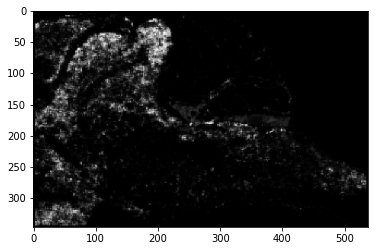

In [59]:
imshow(img, cmap='gray')

In [80]:
10/0.46

21.73913043478261